In [1]:

import string
import re
import spacy 
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

#To Temporarily Remove Deprecation Warning
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /Users/loan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/loan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
data = pd.read_csv('../data/combined_news.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


/Users/loan/anaconda3/envs/cs152/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

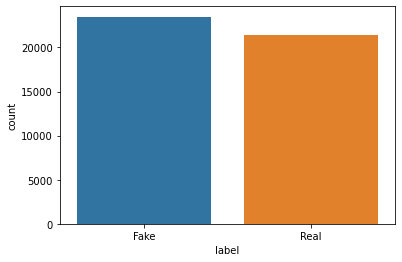

In [16]:
sns.countplot(data['label'])

/Users/loan/anaconda3/envs/cs152/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    44898.000000
mean       415.760412
std        361.648003
min          1.000000
25%        208.000000
50%        371.000000
75%        525.000000
max       8436.000000
Name: length, dtype: float64

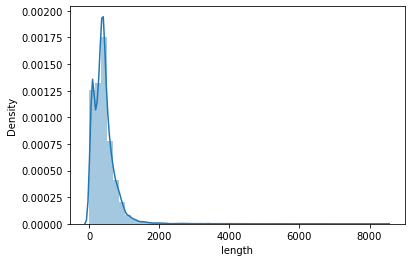

In [4]:
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))
sns.distplot(data['length'])
data['length'].describe()

In [5]:
nlp = spacy.load('en_core_web_sm')

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
# main tokenizing function
def tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):
    # removing unwanted characters and numbers from the string
    pattern = '[' + '|'.join(list(chars_to_exclude)) + '|\d]*'
    line = re.sub(pattern, "", line).lower()

    # generating tokens
    tokens = [token for token in tokenizer.tokenize(line) if token not in stopwords]
    
    # stemming the tokens if the user wants to
    if stem_tokens:
        tokens = [stemmer.stem(token) for token in tokens]

    # lemmatizing the tokens if the user wants to
    if lemm_tokens:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [ ]:
# function to help with tokenizing columns
def tokenize_lines(lines, chars_to_exclude, stopwords, tokenizer=None, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):

    all_tokens = [tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer) for line in lines]

    return np.array(all_tokens)

In [ ]:
# the default parameters for now
def get_default_tokenization_params():
    chars_to_exclude = string.punctuation
    english_stopwords = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer("\w+")

    #Modify these according to the user's choices
    stem_tokens = False
    stemmer = PorterStemmer()

    lemm_tokens = True
    lemmatizer = WordNetLemmatizer()

    return (chars_to_exclude, english_stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer)

In [ ]:

#To-Do: Brush up the following code to highlight the top topics discussed in the data sets: 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis.sklearn

X = tokenize_lines(data['text'], *get_default_tokenization_params())
Y = data['label']
data_processed = pd.DataFrame(({'title': data['title'], 'text': X, 'label': Y}))


# Subsequent section attempts to perform some Topic Modeling using LDA 

# This section focuses on real news
real_news = data_processed[data_processed['label'] == 'Real']
num_topics = 10 
num_features = 100
'''
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])

pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'real_news_lda.html')

# Repeat the above for fake news

'''


In [ ]:
realtext= real_news['text']

In [ ]:
#Gensim library for additional topic modeling and statistical anlysis
#corpora module implements dictionary-mapping btwn words and corresponding int IDs
from gensim import corpora

real_gensim_dictionary = corpora.Dictionary(realtext)
#creating bag of words (bow) w/ realtext
real_gensim_corpus = [real_gensim_dictionary.doc2bow(token, allow_update=True) for token in realtext]

In [ ]:
import pickle
#saving dictionary and bow (via pickle )to use for predictions below
filename1 = 'real_gensim_corpus.pkl'
pickle.dump(real_gensim_corpus, open(filename1, 'wb'))
real_gensim_dictionary.save('real_gensim_dictionary.gensim')

In [ ]:
import gensim
#creating LDA Model
#takes v long to load
real_lda_model = gensim.models.ldamodel.LdaModel(real_gensim_corpus, num_topics=num_topics, id2word=real_gensim_dictionary, passes=10)
real_lda_model.save('real_gensim_model.gensim')

In [ ]:
#printing 5 words per topic
topics = real_lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
#Evaluating LDA: Topic Coherence
#Perplexitiy: -8.169369315206076 (low)
#Coherence: 0.4601994449293338 (high)
#Perplexity is low and coherence is high which is expected as this is real news(?)

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(model=real_lda_model, texts=realtext, dictionary=real_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', real_lda_model.log_perplexity(real_gensim_corpus))
print('\nCoherence Score:', coherence_score)

In [ ]:
#Topic Modeling Visualization

real_gensim_dictionary = gensim.corpora.Dictionary.load('real_gensim_dictionary.gensim')
real_gensim_corpus = pickle.load(open(filename1, 'rb'))
real_lda_model = gensim.models.ldamodel.LdaModel.load('real_gensim_model.gensim')

import pyLDAvis.gensim_models

lda_visualization = pyLDAvis.gensim_models.prepare(real_lda_model, real_gensim_corpus, real_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization)

In [ ]:
#Same as above but for fake news
fake_news = data_processed[data_processed['label'] == 'Fake']
faketext = fake_news['text']

In [ ]:
fake_gensim_dictionary = corpora.Dictionary(faketext)
#creating bag of words (bow) w/ realtext
fake_gensim_corpus = [fake_gensim_dictionary.doc2bow(token, allow_update=True) for token in faketext]

#pickling useful for efficiently storing data to be used later
filename2 = 'fake_gensim_corpus.pkl'
pickle.dump(fake_gensim_corpus, open(filename2, 'wb'))
fake_gensim_dictionary.save('fake_gensim_dictionary.gensim')

In [ ]:
fake_lda_model = gensim.models.ldamodel.LdaModel(fake_gensim_corpus, num_topics=num_topics, id2word=fake_gensim_dictionary, passes=10)
fake_lda_model.save('fake_gensim_model.gensim')

In [ ]:
"""topics = fake_lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)"""

In [ ]:
coherence_score_lda = CoherenceModel(model=fake_lda_model, texts= faketext, dictionary=fake_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', fake_lda_model.log_perplexity(fake_gensim_corpus))
print('\nCoherence Score:', coherence_score)

In [ ]:
"""fake_gensim_dictionary = gensim.corpora.Dictionary.load('fake_gensim_dictionary.gensim')
fake_gensim_corpus = pickle.load(open(filename2, 'rb'))
fake_lda_model = gensim.models.ldamodel.LdaModel.load('fake_gensim_model.gensim')

import pyLDAvis.gensim_models

lda_visualization = pyLDAvis.gensim_models.prepare(fake_lda_model, fake_gensim_corpus, fake_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization)"""

In [17]:
'''
Defining and Training the Model: 
There will be several different types of sequential operations and layers: 

1. A tokenizer to transform each article into a vector of tokens
2. A word embedding layer that learns an embedding vector. 
3. A 1D convolutional and max-pooling layer -- this is to calculate the largest value in each feature map
4. LSTM (Long Short-Term Memory) units: this will form the recurrent part ofn the recurrent convolutional neural network. 
'''

# First step is to import all of the necessary libraries for this experiment

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
# Checking tensorflow version

if float(tf.__version__[0]) < 2.0:
    print("Updating Tensorflow")
    !pip install --upgrade tensorflow
else: 
    print("Correct Version of Tensorflow installed")

'if float(tf.__version__[0]) < 2.0:\n    print("Updating Tensorflow")\n    !pip install --upgrade tensorflow\nelse: \n    print("Correct Version of Tensorflow installed")'

In [18]:
#converting labels from strings to ints
data["label"].replace({"Real": 1, "Fake": 0}, inplace=True)

In [19]:
#Tokenizing Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)

#Padding data
#Keras prefers inputs to be vectorized and all inputs to have the same length. 
#We will pad all input sequences to have the lengthWe will pad all input sequences to have specific length
sequences = tokenizer.texts_to_sequences(data['text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

138021


In [20]:
#Compartmentalizing data into training set and testing set
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = data['label'].values[:split_n]
test_data = padded[split_n:]
test_labels = data['label'].values[split_n:] 

In [21]:
#Using Pre-Trained GloVe for Keras embedding layer
embeddings_index = {};
with open('/Users/loan/Desktop/SP2021/neuralnetworks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


In [22]:
#Temporary model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
#Training model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=2, batch_size=100, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         13802200  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

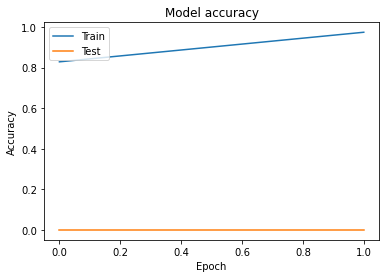

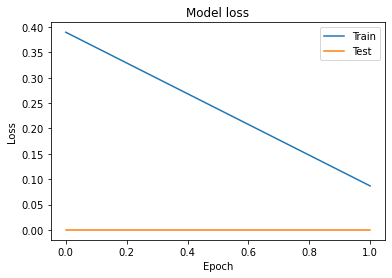

In [24]:
#Visualizing the Results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()